# 4 Modeling<a id='5_Modeling'></a>

## 4.1 Introduction<a id='5.2_Introduction'></a>

In this notebook, we now take our model for predicting market rent and leverage it to gain some insights into which houses for sale may make good investments, as explore the sensitivity of changes to various housing parameters. Note that this relies on the implicit assumption that the market rents upon which we trained and tested the model reflect the actual market rent that people will pay, no more and no less. Essentially this assumes prices are set by a free market.


## 4.2 Imports<a id='5.3_Imports'></a>

In [15]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

## 4.3 Load Model<a id='5.4_Load_Model'></a>

In [16]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = 1.0
model_path = '../models/market_rent_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## 4.4 Load Data<a id='5.5_Load_Data'></a>

In [17]:
sale_data = pd.read_csv('../data/sale_data_I.csv')

In [18]:
corporate_data = pd.read_csv('../data/corporate_data_I.csv')

In [19]:
sale_data.T

,0,1,2,3,4,5,6,7,8,9,...,576,577,578,579,580,581,582,583,584,585
address,19632 W 59th Avenue,2202 Braun Court,642 Deframe,4295 S Braun Court,656 Mc Intyre Street,13130 W 31st Avenue,3229 Zinnia Court,885 Deframe Street,14290 W 50th Avenue,11705 W Tulane Drive,...,5540 W 73rd Avenue,4145 W 80th Place,7101 Wolff Street,8077 Bryant Street,7520 Xavier Street,8121 Tennyson Street,8069 Decatur Court,2573 W 74 Avenue,2486 Ingalls Street,2413 Harlan Street
city,Golden,Golden,Golden,Golden,Golden,Golden,Golden,Golden,Golden,Golden,...,Westminster,Westminster,Westminster,Westminster,Westminster,Westminster,Westminster,Westminster,Edgewater,Edgewater
zipcode,80403,80401,80401,80465,80401,80401,80401,80401,80403,80465,...,80003,80031,80030,80031,80030,80031,80031,80030,80214,80214
beds,4,5,4,3,4,4,5,2,2,3,...,3,3,5,3,3,4,2,4,3,3
baths,3,3,3,3,3,3,3,1,2,2,...,3,2,2,3,2,2,3,2,2,1
sqft,2216,2394,2544,3033,1835,1991,2494,882,882,1473,...,2413,1860,2205,1504,864,2122,1890,2214,1239,1290
value,750000,700000,700000,698900,660000,649500,649000,555000,550000,470000,...,635000,516000,485000,480000,475000,469900,464900,425000,600000,525000
taxes,6807,3024,1976,3226,2767,2318,3119,2573,2469,2438,...,2590,1770,2426,2590,1516,2429,2546,2595,2481,1548
lat,39.804067,39.751799,39.727067,39.637465,39.726388,39.760224,39.762043,39.73062,39.786992,39.634229,...,39.828914,39.8427,39.825593,39.844711,39.8333,39.844361,39.84295,39.830999,39.752725,39.751497
lng,-105.222061,-105.14989,-105.154517,-105.151766,-105.174467,-105.145625,-105.145396,-105.15455,-105.159563,-105.130006,...,-105.057148,-105.042766,-105.048265,-105.019506,-105.04915,-105.047946,-105.02249,-105.017302,-105.063489,-105.062971


## 4.5 Refit Model On All Available Data<a id='5.6_Refit_Model_On_All_Available_Data_'></a>

We now want to refit the model using all available data. 

In [20]:
# set aside the address information
address_list = ['address', 'zipcode', 'lat', 'lng', 'districtMatch', 'city', 'beds', 'baths', 'value']
X = corporate_data.drop(columns='market_rent')
y = corporate_data.market_rent
X.drop(columns=address_list, inplace=True)

In [21]:
len(X), len(y)

(259, 259)

In [22]:
model.fit(X, y)

Lasso(alpha=0.04, max_iter=100000, normalize=True)

In [23]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [24]:
cv_results['test_score']

array([-168.02915662, -103.21334141, -116.28876129, -118.27792022,
       -176.72294835])

In [25]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(136.50642557848374, 29.868086937069986)

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

## 4.6 Calculate Expected Market Rent From The Model<a id='5.7_Calculate_Expected_Market_Rent_From_The_Model'></a>

In [26]:
sale_data.columns

Index(['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'value', 'taxes',
       'lat', 'lng', 'monthly_hoa', 'districtMatch', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofIndianStudents',
       'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
       'percentofWhiteStudents', 'rankMovement',
       'Median household income (in 2019 dollars), 2015-2019', 'beds_3',
       'beds_4', 'beds_5', 'baths_2', 'baths_3', 'baths_4'],
      dtype='object')

In [27]:
sales_drop = ['address', 'zipcode', 'lat', 'lng', 'districtMatch', 'city', 'beds', 'baths', 'monthly_hoa', 'taxes', 'value']
X_sd = sale_data.copy()
X_sd.drop(columns=sales_drop, inplace=True)
X_sd.columns, X_sd.shape

(Index(['sqft', 'percentFreeDiscLunch', 'percentofAfricanAmericanStudents',
        'percentofAsianStudents', 'percentofHispanicStudents',
        'percentofIndianStudents', 'percentofPacificIslanderStudents',
        'percentofTwoOrMoreRaceStudents', 'percentofWhiteStudents',
        'rankMovement', 'Median household income (in 2019 dollars), 2015-2019',
        'beds_3', 'beds_4', 'beds_5', 'baths_2', 'baths_3', 'baths_4'],
       dtype='object'),
 (586, 17))

In [28]:
sd_pred = model.predict(X_sd)

In [29]:
sale_data['market_rent'] = np.round(sd_pred, 2)

In [30]:
round(sale_data['market_rent'].mean(), 2)

2544.59

## 4.7 Market Rents In Market Context<a id='4.8_Market_Rents_In_Market_Context'></a>

Features that came up as important in the modeling included:
* Number of bathrooms
* Square footage
* Number of bedrooms

And to a lesser extent, a White/Indian district indicated increased rents over a Hispanic/African American district. 

The private investor with whom I spoke described his formula for Return-On-Investment. He buys with cash usually, but uses a cost of money of 4% regardless. He estimates the cost of money on the total value of the house at any given time (in our example, the sales price). He uses 1.5 times the monthly rent as a number for maintenance, 0.0056% annually for taxes, and 8% of the rent as administrative overhead. Let's use this information to calculate the potential ROI of the rental properties. 

In [31]:
sale_data.columns

Index(['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'value', 'taxes',
       'lat', 'lng', 'monthly_hoa', 'districtMatch', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofIndianStudents',
       'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
       'percentofWhiteStudents', 'rankMovement',
       'Median household income (in 2019 dollars), 2015-2019', 'beds_3',
       'beds_4', 'beds_5', 'baths_2', 'baths_3', 'baths_4', 'market_rent'],
      dtype='object')

In [32]:
# Calculate ROI
sale_data['%ROI'] = ((12 * sale_data.market_rent) - (0.04 * sale_data.value) - \
    (sale_data.taxes) - (12 * sale_data.monthly_hoa) - (1.5 * sale_data.market_rent) - (12 * 0.08 * sale_data.market_rent))* 100 / sale_data.value

### 4.8 Positive ROI<a id='4.9_Positive_ROI'></a>

Will any of the houses for sale generate a positive ROI according to our model? Will that ROI meet or exceed our corporate investor's estimated profit?

In [33]:
# Calculate ROI for corporate properties
corporate_data['ROI'] = (12 * corporate_data.market_rent) - (0.04 * corporate_data.value) - \
    (corporate_data.value * 0.0056) - - (1.5 * corporate_data.market_rent) - (12 * 0.08 * corporate_data.market_rent)

In [34]:
# calculate a percentage ROI of corporate properties, based on the value of the property
mean_corporate_ROI = ((corporate_data['ROI']/corporate_data['value']) * 100).mean()
print(mean_corporate_ROI)          

2.9697437299258866


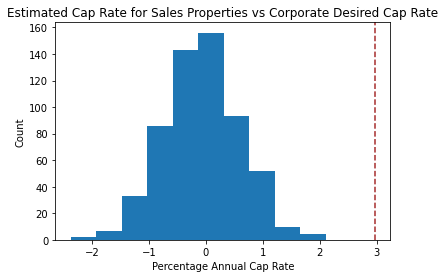

In [40]:
plt.hist(sale_data['%ROI'])
plt.axvline(mean_corporate_ROI, 0, 1, color='brown', linestyle='--')
plt.title("Estimated Cap Rate for Sales Properties vs Corporate Desired Cap Rate")
plt.xlabel("Percentage Annual Cap Rate")
plt.ylabel("Count")
plt.show()

It looks like somewhat less than 50% of properties may generate positive ROI, and none of the properties currently for sale meet the corporate mean ROI. 

In [37]:
# How many of the properties for sale currently exceed the ROI of the properties which lie at the 30 percentile
top = sale_data[sale_data['%ROI']>= mean_corporate_ROI]
top.head(), top.shape

(Empty DataFrame
 Columns: [address, city, zipcode, beds, baths, sqft, value, taxes, lat, lng, monthly_hoa, districtMatch, percentFreeDiscLunch, percentofAfricanAmericanStudents, percentofAsianStudents, percentofHispanicStudents, percentofIndianStudents, percentofPacificIslanderStudents, percentofTwoOrMoreRaceStudents, percentofWhiteStudents, rankMovement, Median household income (in 2019 dollars), 2015-2019, beds_3, beds_4, beds_5, baths_2, baths_3, baths_4, market_rent, %ROI]
 Index: []
 
 [0 rows x 30 columns],
 (0, 30))

Yes, the information we got from the histogram is corrent. Currently there aren't any properties which exceed the ROI of the mean corporate properties ROI (by percentage). 

## 4.9 Summary<a id='5.10_Summary'></a>

Currently, there are not any houses for sale in the Denver metro area that meet the determined criteria for the corporate investor. 




## 4.10 Further work<a id='5.11_Further_work'></a>

Our current dataset of corporate investment properties consist of properties which have been listed on that company's website. This means we only have access to properties which have experienced "turnover" - that is, a change in tenancy. This may lead to the properties listed being a biased subset of all of the owned properties. Perhaps these properties are in more depressed neighborhoods, or are overpriced.  Additionally there are only 188 such properties, and our modeling showed that more properties would lead to a more robust model. .

The following would be interesting to pursue:

-  Would like to know how long the corporation has owned the properties, and how they purchased them
-  Would like to separate for-sale data by full baths / half baths
-  Eventually would be nice to move the demographics/income information to the school level, instead of the district, because the district level information is a bit averaged out. 


Value of a house is intrinsically tied to other factors such as number of bathrooms, sqft, bedrooms, median income in the area and all of the other factors which we explored. It may be better to pursue a model for market rents that does *not* take into account the current value, which changes all the time. 

Many of the yearly ROI costs were estimated. This particular corporate investor puts a larger share of maintenance onto the tenants. Indeed, this corporation and others like it have been the subject of The Atlantic article, "When Wall Street is Your Landlord": https://www.theatlantic.com/technology/archive/2019/02/single-family-landlords-wall-street/582394/
